In [1]:
# LIBRAIRIES IMPORT
# Data
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans # Replace with your model

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import folium

%matplotlib inline

# Metrics
from sklearn import metrics

# Elbow
from yellowbrick.cluster import KElbowVisualizer

In [2]:
# DATA IMPORT
uber = pd.read_csv('../data/Uber.csv')
uber.drop(['Unnamed: 0', 'Hour', 'DayOfWeek'], axis = 1, inplace=True)
uber.head()

Date/Time      Lat      Lon    Base  Period  DayType
0  2014-08-01 00:03:00  40.7366 -73.9906  B02512       0        1
1  2014-08-01 00:09:00  40.7260 -73.9918  B02512       0        1
2  2014-08-01 00:12:00  40.7209 -74.0507  B02512       0        1
3  2014-08-01 00:12:00  40.7387 -73.9856  B02512       0        1
4  2014-08-01 00:12:00  40.7323 -74.0077  B02512       0        1

In [3]:
# MODEL DESCRIPTION
KMeans?

Init signature:
KMeans(
    n_clusters=8,
    *,
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=0.0001,
    verbose=0,
    random_state=None,
    copy_x=True,
    algorithm='auto',
)
Docstring:     
K-Means clustering.

Read more in the :ref:`User Guide <k_means>`.

Parameters
----------

n_clusters : int, default=8
    The number of clusters to form as well as the number of
    centroids to generate.

init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
    Method for initialization:

    'k-means++' : selects initial cluster centers for k-mean
    clustering in a smart way to speed up convergence. See section
    Notes in k_init for more details.

    'random': choose `n_clusters` observations (rows) at random from data
    for the initial centroids.

    If an array is passed, it should be of shape (n_clusters, n_features)
    and gives the initial centers.

    If a callable is passed, it should ta

In [4]:
# SAMPLING
frac_sample = 1
uber_sample = uber.sample(frac = frac_sample, random_state=42)

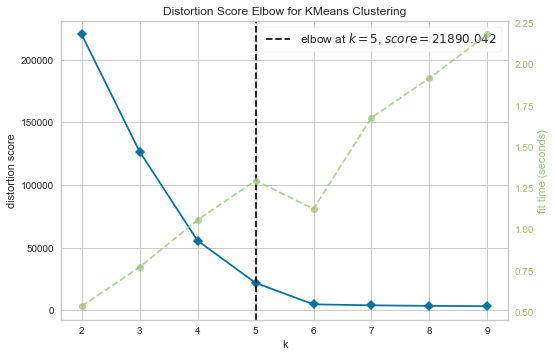

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
# ELBOW HYPERTUNING
X = uber_sample[['Lat','Lon','Period','DayType']]
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(estimator = model, k = (2,10))
visualizer.fit(X)
visualizer.poof()

In [6]:
# 5 it is!

In [7]:
# MODEL FITTING
model = KMeans(n_clusters=5, random_state=42)
model.fit(X)

KMeans(n_clusters=5, random_state=42)

In [8]:
# MODEL PREDICTION
X_predict = X.copy()
X_predict['cluster'] = model.fit_predict(X)
X_predict.cluster.value_counts()

0    342780
1    221164
2    116657
4     75220
3     73454
Name: cluster, dtype: int64

/var/folders/lc/q1lfsr356d11n9j92x9l_x080000gn/T/ipykernel_69781/3448684898.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


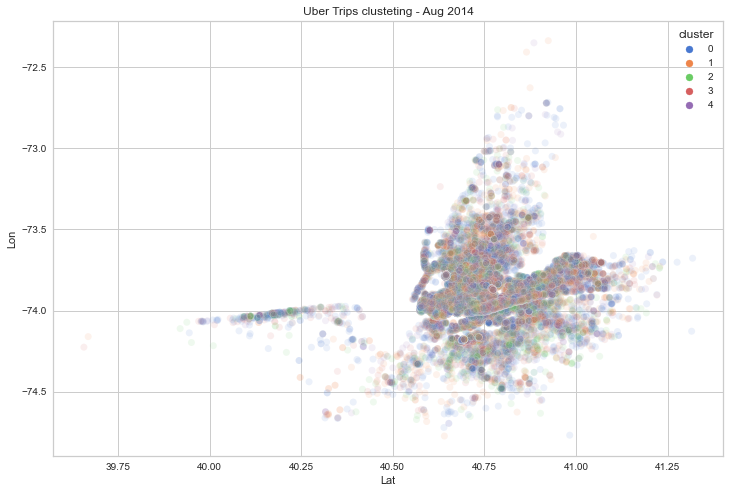

In [9]:
# VISUALISATION

# Seaborn

f,ax = plt.subplots(1,1, figsize=(12,8))
sns.scatterplot(data = X_predict, x='Lat', y='Lon', hue='cluster', ax = ax, palette='muted', alpha = 0.1)
ax.set_title('Uber Trips clusteting - Aug 2014')
f.show()

<AxesSubplot:xlabel='cluster', ylabel='Period'>

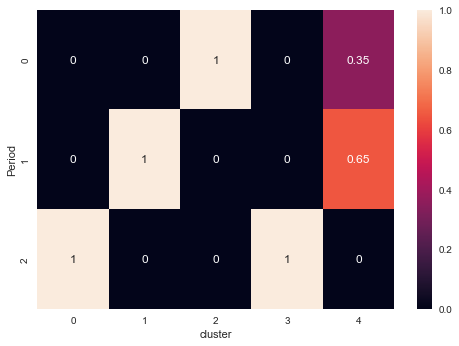

In [10]:
# Heatmaps
# Cluster by Period
sns.heatmap(pd.crosstab(X_predict.Period, X_predict.cluster, normalize='columns'), annot=True)

<AxesSubplot:xlabel='cluster', ylabel='DayType'>

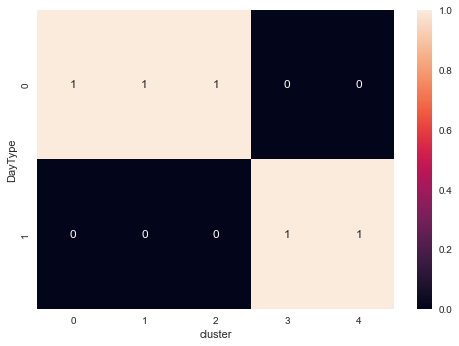

In [14]:
# Cluster by DayType
sns.heatmap(pd.crosstab(X_predict.DayType, X_predict.cluster, normalize='columns'), annot=True)

In [11]:
# Folium

# Initialise map (centered on mean)
map_clusters = folium.Map(location=[uber.Lat.mean(), uber.Lon.mean()],
                zoom_start=9, control_scale=False, zoom_control = False, scrollWheelZoom=False, dragging=False)

# Number of points to show
nb_points = 10000
df_map = X_predict.sample(frac = nb_points/X_predict.shape[0], random_state=42)


# set color scheme for the clusters
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, cluster in zip(df_map['Lat'], df_map['Lon'], df_map['cluster']):
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5,
        stroke = False).add_to(map_clusters)
       
map_clusters

In [12]:
# SCORING

n_clusters = len(X_predict.cluster.unique())
labels = model.labels_

print(f'Estimated number of clusters: {n_clusters:d}')
print(f'Silhouette Score: {metrics.silhouette_score(X, labels, metric="sqeuclidean", random_state=42, sample_size = 10000):0.3f}')
print(f'Calinski-Harabasz Score: {metrics.calinski_harabasz_score(X, labels):.0f}')
print(f'Davies-Bouldin Score: {metrics.davies_bouldin_score(X, labels):0.3f}')

Estimated number of clusters: 5
Silhouette Score: 0.949
Calinski-Harabasz Score: 5440171
Davies-Bouldin Score: 0.417
